In [ ]:
import torch
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
torch.__version__

'1.5.1+cu101'

In [ ]:
cifar_train = datasets.CIFAR10('.', train=True, download=True, transform=transforms.ToTensor())
cifar_valid = datasets.CIFAR10('.', train=False, download=True, transform=transforms.ToTensor())

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
cifar_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
cifar_train[0]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [ ]:
cifar_train[0][0].shape

torch.Size([3, 32, 32])

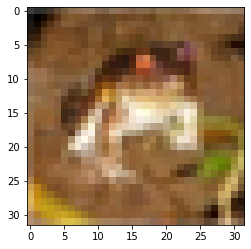

In [ ]:
plt.imshow(cifar_train[0][0].permute(1,2,0))

In [ ]:
len(cifar_train), len(cifar_valid)

(50000, 10000)

In [ ]:
label_dict = {3:0, 9:1}

In [ ]:
cifar_train = [(img,label_dict[lbl]) for img,lbl in cifar_train if lbl in [3,9]]
cifar_valid = [(img,label_dict[lbl]) for img,lbl in cifar_valid if lbl in [3,9]]

In [ ]:
len(cifar_train), len(cifar_valid)

(10000, 2000)

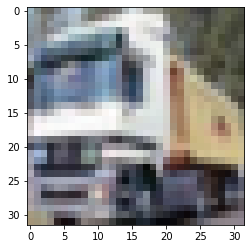

In [ ]:
plt.imshow(cifar_train[0][0].permute(1,2,0))

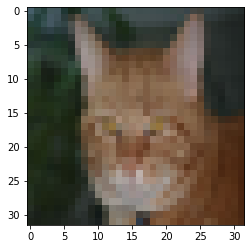

In [ ]:
plt.imshow(cifar_train[5000][0].permute(1,2,0))

In [ ]:
trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(cifar_valid, batch_size=64, shuffle=False)

In [ ]:
trainloader

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(3072, 1024)
        self.l2 = nn.Linear(1024, 256)
        self.l3 = nn.Linear(256, 2)
    def forward(self,x):
        x = F.relu(self.l1(x.view(-1,3072)))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x


In [ ]:
32*32*3

3072

In [ ]:
model = Model().cuda()

In [ ]:
model

Model(
  (l1): Linear(in_features=3072, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
cifar_train[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
cifar_train[0][0].unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [ ]:
model(cifar_train[0][0].unsqueeze(0).cuda())

tensor([[-0.0442, -0.0518]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(100):
    #training
    model.train()
    for img,label in trainloader:
        img = img.cuda()
        label = label.cuda()
        op = model(img)
        loss = criterion(op,label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        total = 0.0
        correct = 0.0
        model.eval()
        for img, label in validloader:
            img = img.cuda()
            label = label.cuda()
            op = model(img)
            op_pred = torch.argmax(op,dim=1)
            correct += torch.sum(op_pred==label)
            total += len(label)
        if epoch%10==0:
            print(epoch, correct/total)


0 tensor(0.8110, device='cuda:0')
10 tensor(0.8615, device='cuda:0')
20 tensor(0.8800, device='cuda:0')
30 tensor(0.8840, device='cuda:0')
40 tensor(0.8930, device='cuda:0')
50 tensor(0.8910, device='cuda:0')
60 tensor(0.8910, device='cuda:0')
70 tensor(0.8910, device='cuda:0')
80 tensor(0.8925, device='cuda:0')
90 tensor(0.8955, device='cuda:0')


In [ ]:
[p.numel() for p in model.parameters()]

[3145728, 1024, 262144, 256, 512, 2]

In [ ]:
1000*1000*3 *1024

3072000000

In [ ]:
3072*1024

3145728

In [ ]:
np.sum([p.numel() for p in model.parameters()])

3409666

Convolutional Neural Network

In [ ]:
mnist = datasets.MNIST('.', train=True, download=True, transform=transforms.ToTensor())

In [ ]:
len(mnist)

60000

In [ ]:
img, lbl = mnist[15000]

In [ ]:
img.shape

torch.Size([1, 28, 28])

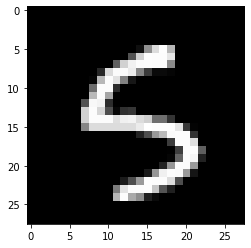

In [ ]:
plt.imshow(img.view(28,28),cmap='gray')

In [ ]:
conv = nn.Conv2d(1,5,3,1)

In [ ]:
conv.weight.shape

torch.Size([5, 1, 3, 3])

In [ ]:
conv_res = conv(img.unsqueeze(0))

In [ ]:
conv_res.shape

torch.Size([1, 5, 26, 26])

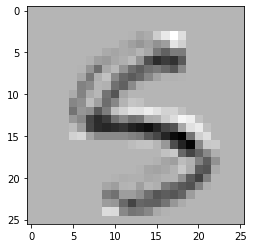

In [ ]:
plt.imshow(conv_res[0][0].detach(), cmap='gray')

In [ ]:
conv.bias

Parameter containing:
tensor([-0.0781,  0.3070, -0.0799,  0.1156, -0.0606], requires_grad=True)

In [ ]:
with torch.no_grad():
    conv.bias.zero_()

In [ ]:
conv.bias

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)

In [ ]:
conv.weight[0]

tensor([[[-0.2525, -0.0748,  0.1722],
         [-0.1119,  0.0143, -0.2242],
         [ 0.1828,  0.0756, -0.0939]]], grad_fn=<SelectBackward>)

In [ ]:
conv.weight[0] = torch.tensor([[[1.,1.,1.],[0.,0.,0],[-1.,-1.,-1]]])

In [ ]:
conv.weight[1] = torch.tensor([[[1.,0.,-1.],[1.,0.,-1],[1.,0.,-1]]])
conv.weight[2] = torch.tensor([[[1.,1.,1.], [1.,1.,1.],[1.,1.,1.]]])

In [ ]:
conv.weight[0]

tensor([[[ 1.,  1.,  1.],
         [ 0.,  0.,  0.],
         [-1., -1., -1.]]], grad_fn=<SelectBackward>)

In [ ]:
conv.weight[1]

tensor([[[ 1.,  0., -1.],
         [ 1.,  0., -1.],
         [ 1.,  0., -1.]]], grad_fn=<SelectBackward>)

In [ ]:
conv_res = conv(img.unsqueeze(0))

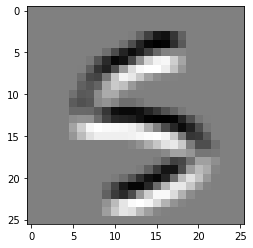

In [ ]:
plt.imshow(conv_res[0][0].detach(), cmap='gray')

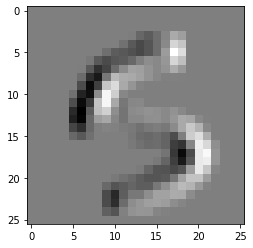

In [ ]:
plt.imshow(conv_res[0][1].detach(), cmap='gray')

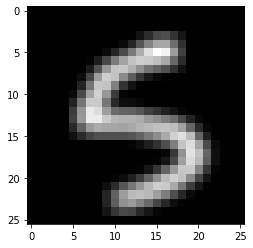

In [ ]:
plt.imshow(conv_res[0][2].detach(), cmap='gray')

In [ ]:
# Padding

In [ ]:
conv_pad = nn.Conv2d(1,5,kernel_size=3, stride=1, padding=1)

In [ ]:
with torch.no_grad():
    conv_pad.bias.zero_()

In [ ]:
conv_pad.weight[0] = torch.tensor([[[1.,1.,1.],[0.,0.,0.],[-1.,-1.,-1.]]])

In [ ]:
conv_pad_res = conv_pad(img.unsqueeze(0))

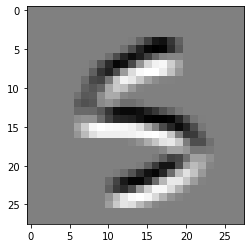

In [ ]:
plt.imshow(conv_pad_res[0][0].detach(), cmap='gray')

# Stride

In [ ]:
conv_stride = nn.Conv2d(1,5,kernel_size=3, stride=2, padding=1)

In [ ]:
with torch.no_grad():
    conv_stride.bias.zero_()
conv_stride.weight[0] = torch.tensor([[[1.,1.,1.],[0.,0.,0.],[-1.,-1.,-1.]]])

In [ ]:
conv_stride_res = conv_stride(img.unsqueeze(0))

In [ ]:
conv_stride_res.shape

torch.Size([1, 5, 14, 14])

# MaxPooling

In [ ]:
max_pool = nn.MaxPool2d(2)

In [ ]:
max_res = max_pool(img.unsqueeze(0))

In [ ]:
max_res.shape

torch.Size([1, 1, 14, 14])

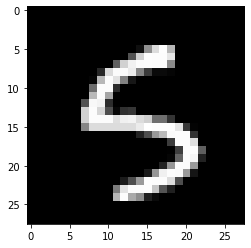

In [ ]:
plt.imshow(img.view(28,28), cmap='gray')

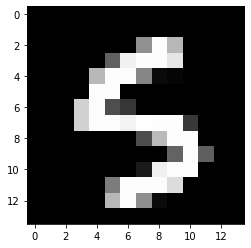

In [ ]:
plt.imshow(max_res.detach().view(14,14), cmap='gray')

In [ ]:
img.unsqueeze(0).shape, img.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 28, 28]))

In [ ]:
img.unsqueeze_(0)

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
img.shape

torch.Size([1, 1, 28, 28])

# CNN Model

In [ ]:
8*8*16

1024

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64,16, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.fc1(x.view(-1,8*8*16)))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN().cuda()

In [ ]:
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(100):
    #training
    model.train()
    for img,label in trainloader:
        img = img.cuda()
        label = label.cuda()
        op = model(img)
        loss = criterion(op,label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        total = 0.0
        correct = 0.0
        model.eval()
        for img, label in validloader:
            img = img.cuda()
            label = label.cuda()
            op = model(img)
            op_pred = torch.argmax(op,dim=1)
            correct += torch.sum(op_pred==label)
            total += len(label)
        if epoch%10==0:
            print(epoch, correct/total)


0 tensor(0.7685, device='cuda:0')
10 tensor(0.9095, device='cuda:0')
20 tensor(0.9290, device='cuda:0')
30 tensor(0.9400, device='cuda:0')
40 tensor(0.9460, device='cuda:0')
50 tensor(0.9425, device='cuda:0')
60 tensor(0.9525, device='cuda:0')
70 tensor(0.9450, device='cuda:0')
80 tensor(0.9540, device='cuda:0')
90 tensor(0.9580, device='cuda:0')


In [ ]:
[p.numel() for p in model.parameters()]

[1728, 64, 9216, 16, 32768, 32, 64, 2]

In [ ]:
np.sum([p.numel() for p in model.parameters()])

43890